In [242]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler


In [243]:
enfermedades = pd.read_excel('archivos/CIE.xlsx')
new_df = pd.read_csv('archivos/NewDataAll.csv', low_memory= False)
enfermedades.head(5)



,CAUSA,DESCRIP
0,A00,Cólera
1,A000,"Cólera debido a Vibrio cholerae 01, biotipo ch..."
2,A001,"Cólera debido a Vibrio cholerae 01, biotipo el..."
3,A009,"Cólera, no especificado"
4,A01,Fiebres tifoidea y paratifoidea


In [244]:
# Preprocesar los datos
new_df['caudef']
enfermedades2 = enfermedades.copy()
enfermedades2.loc[enfermedades2['CAUSA'].str.len() == 3, 'CAUSA'] = enfermedades2.loc[enfermedades2['CAUSA'].str.len() == 3, 'CAUSA'] + "X"

new_df2 = pd.merge(new_df, enfermedades2, left_on='caudef', right_on='CAUSA', how='left')
new_df2 = new_df2.dropna()
causas_infecciones = new_df2.loc[new_df2["DESCRIP"].str.contains("Infecciones|infecciones|infeccion|Infección|Infeccion|infección")]
causas_vih = new_df2.loc[new_df2["DESCRIP"].str.contains("VIH|vih|SIDA")]
# Filtrar las características y la variable objetivo
new_df2['VIH'] = 0
indices_vih = new_df2[new_df2['DESCRIP'].str.contains("VIH|vih|SIDA")].index
new_df2.loc[indices_vih, 'VIH'] = 1


Exactitud (Accuracy): 0.5690524644271078
Precisión (Precision): 0.5520174685984052
Recall: 0.7353345827600776
Puntaje F1 (F1 Score): 0.6306239765878131
Matriz de confusión:
[[ 74242 110171]
 [ 48862 135756]]
Especificidad: 0.40258550102216223
Puntajes de validación cruzada: [0.99453994 0.9945453  0.99453991 0.99453991 0.99453991]
Promedio del puntaje de validación cruzada: 0.9945409916131936


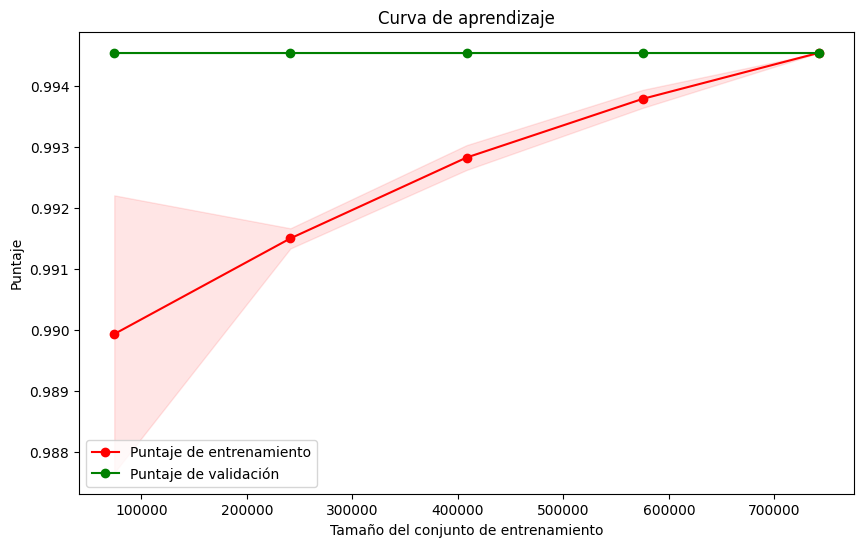

In [245]:
data = new_df2[['sexo', 'añoreg']]
target = new_df2['VIH']

# Realizar el sobremuestreo de la clase minoritaria
oversampler = RandomOverSampler(random_state=42)
data_resampled, target_resampled = oversampler.fit_resample(data, target)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data_resampled, target_resampled, test_size=0.2, random_state=42)
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train_scaled, y_train)

# Realizar la predicción en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
specificity = confusion[0, 0] / (confusion[0, 0] + confusion[0, 1])

# Calcular las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model, data, target, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Realizar la validación cruzada con 5 particiones
cross_val_scores = cross_val_score(model, data, target, cv=5)

# Imprimir los resultados
print("Exactitud (Accuracy):", accuracy)
print("Precisión (Precision):", precision)
print("Recall:", recall)
print("Puntaje F1 (F1 Score):", f1)
print("Matriz de confusión:")
print(confusion)
print("Especificidad:", specificity)
print("Puntajes de validación cruzada:", cross_val_scores)
print("Promedio del puntaje de validación cruzada:", np.mean(cross_val_scores))

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntaje de entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Puntaje de validación")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Puntaje")
plt.title("Curva de aprendizaje")
plt.legend(loc="best")
plt.show()